# nndist_scaling

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.ma as ma
import matplotlib.pyplot as plt
from math import erf
from scipy.optimize import curve_fit
from tqdm import tqdm

In [10]:
## functions
def load_IDs(L, seeds):
    Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

    ID = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID']*data[i]['rsquared'] for i in range(len(Ws))])
        except:
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    return ID


def bins_upper(L):
    bins_upper_dict = {8:10,10:20,12:35,14:70}
    return bins_upper_dict[L]

def make_hists(Ws, num_seeds=100, L=8, plot=False):    
    hists = {}
    for i,W in tqdm(enumerate(Ws)):
        histogram = 0
        for seed in range(num_seeds):
            data = np.atleast_2d(np.load("data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]

            h, binedges = np.histogram(data[i]['nndist'], bins=np.linspace(0,bins_upper(L),100))
            histogram += h
        if plot:
            plt.plot(np.linspace(0,bins_upper(L),100)[:-1], histogram/num_seeds, label=W)
        hists[W] = histogram
    return hists

def fit_normal(L, Ws, hists):
    mu = {}
    sigma = {}
    for W in Ws:
        y = hists[W]
        x = np.linspace(0,bins_upper(L),100)[:-1]
        popt, pcov = curve_fit(normal, x,y, maxfev=10000, p0=[5000,4,15])
        mu[W] = popt[2]
        sigma[W] = popt[1]
    return mu, sigma

def logistic(x,a,k, b, x_0):
    return a/(1+np.exp(k*(x-x_0))) +b


@np.vectorize
def Erf(x):
    return erf(x)

def normal(x, a,sigma, mu):
    return a/(sigma*(2*np.pi)**0.5) * np.exp(-.5*((x-mu)/sigma)**2)


def skew_normal(x,A,a, omega,epsilon):
    sqrt_2_pi = (2*np.pi)**.5
    psi = 2/omega * 1/sqrt_2_pi * np.exp(-.5* ((x-epsilon)/omega)**2)
    Psi = 1/2 * (1+Erf(a*(x-epsilon)/(omega*(2)**.5)))
    return  A*psi * Psi


def dydx2(x,y):
    
    dx = xdata[1]-xdata[0]
    dydx = np.gradient(ydata, dx)
    dydx2_ = np.gradient(dydx, dx)
    return dydx2_


## Make histograms

## Load histograms

In [13]:
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

data = np.load('data/hists_mu_sigma.npz', allow_pickle=True)
data = data[data.files[0]].item()

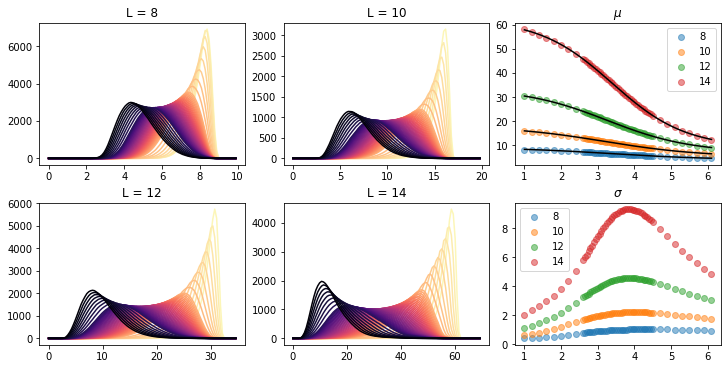

In [70]:
fig = plt.figure(figsize=(10, 5), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=4)

ax00 = fig.add_subplot(spec[:2, 0])
ax01 = fig.add_subplot(spec[:2, 1])
ax02 = fig.add_subplot(spec[2:, 0])
ax03 = fig.add_subplot(spec[2:, 1])
ax2 = fig.add_subplot(spec[:2, 2:])
ax3 = fig.add_subplot(spec[2:, 2:])

colors = sns.color_palette("magma_r", len(Ws))
sigma_peaks, mu_0 = [], []

for i, L, ax, in zip(range(4), [8,10,12,14], [ax00,ax01,ax02,ax03]):
    #print(L)
    ax.set_title(f'L = {L}')
    
    for c, W in zip(colors, Ws):
        ax.plot(np.linspace(0,bins_upper(L),100)[:-1], data[L]['hists'][W]/100, c=c)

    
    ax2.scatter(data[L]['mu'].keys(),data[L]['mu'].values(), label=L, alpha=.5)
    
    try:
        xdata = np.linspace(min(data[L]['mu'].keys()),max(data[L]['mu'].keys()), 10000)
        popt, pcov = curve_fit(logistic, 
                               np.array(list(data[L]['mu'].keys()))[:],
                               np.array(list(data[L]['mu'].values()))[:], 
                               p0=[12.6, .75, 5.,3.9], method='dogbox', maxfev=20000)
        
        ydata = logistic(xdata, *popt)
        ax2.plot(xdata,logistic(xdata, *popt), c='black')
        mu_0.append(popt[-1])
        #print(popt, xdata[np.argmax(ydata)])
        out['logistic'][L] = popt
    except:
        print(L, 'failed logistic')

    
    ax3.scatter(data[L]['sigma'].keys(),data[L]['sigma'].values(), label=L, alpha=.5)
    sigma_peaks.append(np.array(list(data[L]['sigma'].keys()))[np.argmax(np.array(list(data[L]['sigma'].values())))])
    

    
ax2.set_title('$\mu$')
ax3.set_title('$\sigma$')
ax2.legend()
ax3.legend()

plt.savefig('figures/nndist_2.png',dpi=420)



array([0.99076169, 6.59157017, 3.69723655])

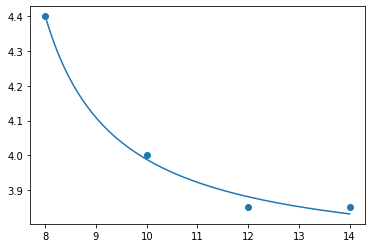

In [66]:
xdata = np.arange(8,16,2)
ydata = sigma_peaks
plt.scatter(xdata,ydata)

def asymptote(x, a,b,c):
    return a/(x-b) + c


popt, pcov = curve_fit(asymptote, 
                               xdata,
                               ydata, 
                               p0=[12.6, .75, 5.], method='dogbox', maxfev=20000)
xdata = np.linspace(min(xdata), max(xdata), 10000)
plt.plot(xdata, asymptote(xdata, *popt))

popt

array([-1.13301209e+04, -3.51621064e+03,  6.50588291e+00])

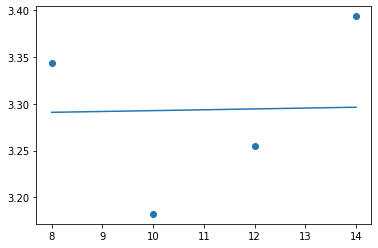

In [55]:
xdata = np.arange(8,16,2)
ydata = mu_0
plt.scatter(xdata,ydata)

def asymptote(x, a,b,c):
    return a/(x-b) + c


popt, pcov = curve_fit(asymptote, 
                               xdata,
                               ydata, 
                               p0=[12.6, .75, 5.], method='dogbox', maxfev=20000)
xdata = np.linspace(min(xdata), max(xdata), 10000)
plt.plot(xdata, asymptote(xdata, *popt))

popt

## Scaling Collapse
We should do this for both mu and sigma

In [40]:
sigma_peaks

[4.485178517851786, 4.092439243924393, 3.980228022802281, 3.9792079207920796]